# Gene-wise testing in depth, including multiple testing

https://compbiocore.github.io/cbc-workshop-directory/

**Abstract**

This session starts with some brief theory relevant to RNA-seq differential expression analysis, including model formulae, design matrices, generalized linear models, sampling, blocking, and stratification. It briefly summarizes the main approaches to RNA quantification, and to differential expression analysis in Bioconductor, then covers a workflow for differential expression hypothesis testing, visualization, and batch correction. 

# Review - Model formulae

[Model formulae tutorial](http://ww2.coastal.edu/kingw/statistics/R-tutorials/formulae.html)

* many regression functions in R use a "model formula" interface.
* The formula determines the model that will be built (and tested) by the R procedure. The basic format is:

`> response variable ~ explanatory variables`

* The tilde means "is modeled by" or "is modeled as a function of." 

## Essential model formulae terminology

symbol  | example | meaning
------- | ------------ | --------------------------  
+ | + x	| include this variable  
-	| - x	| delete this variable  
:	| x : z	| include the interaction  
*	| x * z	| include these variables and their interactions  
^	| (u + v + w)^3	| include these variables and all interactions up to three way
1 | -1 | intercept: delete the intercept  

Note: order generally doesn't matter (u+v OR v+u)

*Examples*: `~treatment`, `~treatment + time`, `~treatment * time`


# The Design Matrix

## The Design Matrix

Use an example of a multiple linear regression model:

$y_i = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_p x_{pi} + \epsilon_i$

- $x_{ji}$ is the value of predictor $x_j$ for observation $i$

## The Design Matrix

Matrix notation for the multiple linear regression model:

$$
\,
\begin{pmatrix}
Y_1\\
Y_2\\
\vdots\\
Y_N
\end{pmatrix} = 
\begin{pmatrix}
1&x_1\\
1&x_2\\
\vdots\\
1&x_N
\end{pmatrix}
\begin{pmatrix}
\beta_0\\
\beta_1
\end{pmatrix} +
\begin{pmatrix}
\varepsilon_1\\
\varepsilon_2\\
\vdots\\
\varepsilon_N
\end{pmatrix}
$$

or simply: 

$$
\mathbf{Y}=\mathbf{X}\boldsymbol{\beta}+\boldsymbol{\varepsilon}
$$

* The design matrix is $\mathbf{X}$
    * which the computer will take as a given when solving for $\boldsymbol{\beta}$ by minimizing the sum of squares of residuals $\boldsymbol{\varepsilon}$.
    

There are multiple possible and reasonable design matrices for a given study design
* the model formula encodes a default model matrix, e.g.:

In [ ]:
group <- factor( c(1, 1, 2, 2) )
model.matrix(~ group)

What if we forgot to code group as a factor?

In [ ]:
group <- c(1, 1, 2, 2)
model.matrix(~ group)

Here is an example again of a single predictor, but with more groups

In [ ]:
group <- factor(c(1,1,2,2,3,3))
model.matrix(~ group)

The _baseline_ group is the one that other groups are contrasted against. You can change the baseline group:

In [ ]:
group <- factor(c(1,1,2,2,3,3))
group <- relevel(x=group, ref=3)
model.matrix(~ group)

The model matrix can represent multiple predictors, ie multiple (linear/log-linear/logistic) regression:

In [ ]:
diet <- factor(c(1,1,1,1,2,2,2,2))
sex <- factor(c("f","f","m","m","f","f","m","m"))
model.matrix(~ diet + sex)

And interaction terms:

In [ ]:
model.matrix(~ diet + sex + diet:sex)

# Experimental Design - Blocking and Stratification

Blocking and stratification are related concepts that group more similar records together. 

## Blocking in experimental design
- The differences between the "blocks" of individuals is "nuisance" variability that we want to control

 <img src="http://faculty.csupueblo.edu/paul.Chacon/156Spr05/images/block.jpg" alt="blocking" style="width:500px"> 

- blocking is typical in biology experiments to:
    + apply an experimental randomization to more homogeneous "blocks" of individuals
    + assign treated and control specimens, or case & control specimens, equally and randomly to batches (really the same as above)

- blocks are normally included as a factor in regression analysis
    + can adjust for nuisance variables afterwards, but *include in experimental design wherever possible*
     

# Differential expression analysis

- The first part of this workshop gave a broad overview of different approaches to exploring your RNAseq data and generating counts matrices and SummarizedExperiment objects.
- The counts matrices stored in the SummarizedExperiment objects can then be used for differential expression analysis.       

We could use a variety of Bioconductor packages for more exploration and differential expression analysis of the count data, including:
* [DESeq2](http://www.bioconductor.org/packages/DESeq2)
* [edgeR](http://www.bioconductor.org/packages/edgeR)
* [limma](http://www.bioconductor.org/packages/limma) (use Voom method for RNA-seq)

[Schurch *et al.* 2016](https://www.ncbi.nlm.nih.gov/pmc/articles/pmid/27022035/) compared performance of different statistical methods for RNA-seq using a large number of biological replicates and can help users to decide which tools make sense to use, and how many biological replicates are necessary to obtain a certain sensitivity. 

##  Comparison of edgeR / DESeq2 / limma-voom

**DESeq2**, **edgeR**, and **limma-voom** are all well-documented packages. They each implement similar key features:        

* Empirical Bayes "regularization" or "shrinkage" of expression variance
   + borrows prior expectation for variance from all genes, reduces false positives in small samples
* Use of model formula, model matrices, and contrasts for flexible differential expression analysis      
* Reporting of log fold-change and False Discovery Rate 

Some ways they differ are:
* Error terms used: **DESeq2** and **edgeR** use log-linear Generalized Linear Model with negative binomial error term , **limma-voom** uses linear regression on transformed counts     
    
* **DESeq2** "automagically" handles independent filtering, using Independent Hypothesis Weighting ([IHW package](http://www.bioconductor.org/packages/IHW))
* Speed (**limma-voom** is much faster and should definitely be used if you have hundreds of samples)
* Approaches to hierarchical modeling, e.g. samples nested within groups
    + **limma-voom** has a built-in feature for sample correlations (called *duplicateCorrelation*)
* Re-use of core Bioconductor structures (**DESeq2** extends *SummarizedExperiment*, **edgeR** and **limma** create their own data structures)          

* **DEseq2** is generally a practical and simple pipeline to run, but for large datasets (especially if doing permutations for gene set enrichment analysis) **limma-voom** might be a more practical choice.      
* For large samples sizes it hardly matters which error model you use owing to the Central Limit Theorem. 

For this workshop we will continue using [**DESeq2**](http://www.bioconductor.org/packages/DESeq2), starting from the *SummarizedExperiment* object.

# Running the differential expression pipeline

As we have already specified an experimental design when we created the *DESeqDataSet*, we can run the differential expression pipeline on the raw counts with a single call to the function *DESeq*. 

First, let's load some packages and the airway data.

In [2]:
suppressPackageStartupMessages({
    library('DESeq2')
    library('airway')
    library('biomaRt')
    library('dplyr')
    library('apeglm')
})
data(airway)

As in the previous workshop, we can turn the `RangedSummarizedExperiment` into a `DESeqDataSet`:

In [3]:
dds <- DESeqDataSet(airway, design = ~ cell + dex)
dds

class: DESeqDataSet 
dim: 64102 8 
metadata(2): '' version
assays(1): counts
rownames(64102): ENSG00000000003 ENSG00000000005 ... LRG_98 LRG_99
rowData names(0):
colnames(8): SRR1039508 SRR1039509 ... SRR1039520 SRR1039521
colData names(9): SampleName cell ... Sample BioSample

We can look at the factor levels of `dex`

In [4]:
levels(colData(dds)$dex)

[1] "trt"   "untrt"

We probably want `untrt` to be our reference level (although this isn't super critical when there are only two factor levels).

In [5]:
colData(dds)$dex <- relevel(colData(dds)$dex, ref = 'untrt')
levels(colData(dds)$dex)

[1] "untrt" "trt"

In [6]:
?DESeq

Use the `DESeq` function to run differential expression analysis

In [6]:
dds <- DESeq(dds)
dds

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



class: DESeqDataSet 
dim: 64102 8 
metadata(2): '' version
assays(4): counts mu H cooks
rownames(64102): ENSG00000000003 ENSG00000000005 ... LRG_98 LRG_99
rowData names(34): baseMean baseVar ... deviance maxCooks
colnames(8): SRR1039508 SRR1039509 ... SRR1039520 SRR1039521
colData names(10): SampleName cell ... BioSample sizeFactor

This function will print out a message for the various steps it performs. These are described in more detail in the manual page for DESeq, which can be accessed by typing '?DESeq'. Briefly these are: the estimation of size factors (controlling for differences in the sequencing depth of the samples), the estimation of dispersion values (the spread or variability) for each gene, and fitting a generalized linear model (GLM).

A DESeqDataSet is returned that contains all the fitted parameters within it, and the following section describes how to extract out results tables of interest from this object.

## Building the results table

Calling `results` without any arguments will extract the estimated log2 fold changes and p-values **for the last variable in the design formula**. If there are more than 2 levels for this variable, `results` will extract the results table for a comparison of the last level over the first level.

Here, our model was `~ cell + dex`, so the comparison printed at the top of the output is
`dex trt vs dex untrt`.  

In [7]:
res <- results(dds)
head(res)

log2 fold change (MLE): dex trt vs untrt 
Wald test p-value: dex trt vs untrt 
DataFrame with 6 rows and 6 columns
                  baseMean log2FoldChange     lfcSE      stat      pvalue
                 <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000000003 708.602170     -0.3812539  0.100654 -3.787751 0.000152017
ENSG00000000005   0.000000             NA        NA        NA          NA
ENSG00000000419 520.297901      0.2068127  0.112219  1.842944 0.065337210
ENSG00000000457 237.163037      0.0379206  0.143445  0.264357 0.791504963
ENSG00000000460  57.932633     -0.0881677  0.287142 -0.307053 0.758803336
ENSG00000000938   0.318098     -1.3782340  3.499875 -0.393795 0.693732273
                      padj
                 <numeric>
ENSG00000000003 0.00128364
ENSG00000000005         NA
ENSG00000000419 0.19654584
ENSG00000000457 0.91145800
ENSG00000000460 0.89503445
ENSG00000000938         NA

**Note that there are some rows that are composed primarily of NAs - that is because we are running `DESeq` on the untransformed data, not the data we manipulated for exploratory data analysis in our first workshop. These NA rows are generated when the total counts for a gene are very low as a way of ignoring them in later stages of the analysis, in a manner analogous to our manual filtering from Workshop 1.**

We could have equivalently produced this results table using the `contrast` argument. Because `dex` is the last variable in the design, we left off the `contrast` argument to extract the comparison of the two levels of `dex` in our first run of `results`; here, we run the exact same comparison explicitly.

**When we do so, we store it in a different object so we can compare the two and verify that they're the same**.  It is generally a good idea to assign the results of every command to a different object so we can view them all together if need be; furthermore, if there is an error, we can immediately get back to the last successful command with the least possible disruption.

In [8]:
res.specific <- results(dds, contrast=c("dex","trt","untrt"))
head(res.specific)

log2 fold change (MLE): dex trt vs untrt 
Wald test p-value: dex trt vs untrt 
DataFrame with 6 rows and 6 columns
                  baseMean log2FoldChange     lfcSE      stat      pvalue
                 <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000000003 708.602170     -0.3812539  0.100654 -3.787751 0.000152017
ENSG00000000005   0.000000             NA        NA        NA          NA
ENSG00000000419 520.297901      0.2068127  0.112219  1.842944 0.065337210
ENSG00000000457 237.163037      0.0379206  0.143445  0.264357 0.791504963
ENSG00000000460  57.932633     -0.0881677  0.287142 -0.307053 0.758803336
ENSG00000000938   0.318098     -1.3782340  3.499875 -0.393795 0.693732273
                      padj
                 <numeric>
ENSG00000000003 0.00128364
ENSG00000000005         NA
ENSG00000000419 0.19654584
ENSG00000000457 0.91145800
ENSG00000000460 0.89503445
ENSG00000000938         NA

If `log2FoldChange` values are negative that means they are down regulated in `trt` because compared dex `trt` vs `untrt`.

We can also look into the `res` object a little more. Since it is a *DataFrame* object, it carries metadata with information on the meaning of the columns:

In [9]:
mcols(res, use.names = TRUE)

DataFrame with 6 rows and 2 columns
                       type                               description
                <character>                               <character>
baseMean       intermediate mean of normalized counts for all samples
log2FoldChange      results  log2 fold change (MLE): dex trt vs untrt
lfcSE               results          standard error: dex trt vs untrt
stat                results          Wald statistic: dex trt vs untrt
pvalue              results       Wald test p-value: dex trt vs untrt
padj                results                      BH adjusted p-values

* The first column, `baseMean`, is a just the average of the normalized count values, divided by the size factors, taken over all samples in the *DESeqDataSet*.     

The remaining four columns refer to a specific contrast, namely the comparison of the `trt` level over the `untrt` level for the factor variable `dex`. We will find out below how to obtain other contrasts.     

 * The column `log2FoldChange` is the effect size estimate. It tells us how much the gene's expression has changed due to treatment with dexamethasone in comparison to untreated samples.  This value is reported on a logarithmic scale to base 2: for example, a log2 fold change of 1.5 means that the gene's expression is increased by a multiplicative factor of $2^{1.5} \approx 2.82$.     

* The column `lfcSE` is the uncertainty associated with the `log2FoldChange` or the *standard error estimate* for the log2 fold change estimate.  We can also express the uncertainty of a particular effect size estimate as the result of a statistical test.     

* The `stat` column is the Wald statistic (`log2FoldChange` divided by `lfcSE`).    

* The `pvalue` column compares the Wald statistic to a Normal distribution to generate a two-tailed `pvalue`. 

* `padj` is the Benjamini-Hochberg corrected p-value 


We can also summarize the results table using the `summary` function:

In [10]:
summary(res)


out of 33469 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2604, 7.8%
LFC < 0 (down)     : 2215, 6.6%
outliers [1]       : 0, 0%
low counts [2]     : 15441, 46%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



First, note that `summary` describes only those genes with a nonzero read count - i.e. it ignores the NA-only rows that we noticed when viewing the top of the results table.  R has a convenient way to detect and ignore NAs that Bioconductor is using internally; we will discuss this method, and how to invoke it manually, a bit later.

Next, note that there are many genes with differential expression due to
dexamethasone treatment at the FDR level of 10%. This makes sense, as
the smooth muscle cells of the airway are known to react to
glucocorticoid steroids. However, there are two ways to be more strict
about which set of genes are considered significant:

* lower the false discovery rate threshold (the threshold on `padj` in
  the results table)
* raise the log2 fold change threshold from 0 using the `lfcThreshold`
  argument of *results*

If we lower the false discovery rate threshold, we should also
inform the `results()` function about it, so that the function can use this 
threshold for the optimal independent filtering that it performs:

## A Note on Statistical Terminology

* For large samples, violations of distributional assumptions have diminishing importance
* _Standard Error_ is the standard deviation of a normally distributed sampling distribution
* The null hypothesis is an assumption about the form of a sampling distribution

Generally, in a biological experiment, the null hypothesis is that there is no difference between two (or more) different groups according so some metric being studied e.g. gene expression. The alternative hypothesis is that there is some difference. To determine which of these hypotheses is more likely to be correct, we calculate a p-value.

**p-value:** the probability of getting a result at least as extreme as the one observed *given* that the null hypothesis is true 

In other words, a low p-value means it's unlikely that you'd see what you're seeing if the null hypothesis is true (in our case, that the groups studied show no difference in gene expression). A low p-value (classically lower than 0.05) provides evidence that the null hypothesis is not true, so we reject the null hypothesis. This is not the same as accepting the alternative hypothesis, but with the null rejected we only have the alternative hypothesis left.

**The purpose of a test for differential expression is to test whether the data provides sufficient evidence to conclude that there are differences in gene expression across groups for a reason other than random chance**. 

*DESeq2* performs, for each gene, a *hypothesis test* to see whether evidence is sufficient to decide against the *null hypothesis*. The null hypothesis is that there is no effect of the treatment on the gene and that the observed difference between treatment and control was merely caused by experimental variability (i.e., the type of variability that you can expect between different samples in the same treatment group). As usual in statistics, the result of this test is reported as a p-value, and it is found in the column `pvalue`. Remember that a p-value indicates the probability that a fold change as strong as the observed one, or even stronger, would be seen under the situation described by the null hypothesis.

## Multiple testing

In high-throughput biology, we are careful to not use the p-values directly as evidence against the null, but instead to correct for *multiple testing*. What would happen if we were to simply threshold the p-values at a low value, say 0.05? There are 5676 genes with a p-value below 0.05 among the 33469 genes for which the test succeeded in reporting a *p* value:

In [11]:
sum(res$pvalue < 0.05)

[1] NA

This code, though written correctly, yields a result of NA, meaning the data is missing. Why is that?

In [12]:
table(is.na(res$pvalue))


FALSE  TRUE 
33469 30633 

In the code above, we count the number of `NA`s in our data and see that there are many of them. By default, R uses all data in performing its calculations, so the presence of even one NA will lead to a result of NA. However, as alluded to before, there is a simple way to have R ignore NAs when running a calculation -- by using `na.rm = TRUE`.

Important Note: na.rm = TRUE is an argument that tells R to ignore missing values when performing a given operation - since NA is not a valid number, most calculations involving any NA values returns NA. High-dimensional data analysis usually does include some missing values, so this argument is important.

The command means "remove NAs", but it doesn't physically remove them from the actual data object - it just temporarily removes them for the purposes of the single command it's invoked upon. Thus, it's easy to keep track of the NAs in the original data set since they're not modified in any way.



## Other comparisons

The results for a comparison of any two levels of a
variable can be extracted using the `contrast` argument to
*results*. The user should specify three values: 
- the name of the variable   
- the name of the level for the numerator    
- and the name of the level for the denominator       

Here we extract results for the log2 of thefold change of one cell line over another. We will explicitly specify which cell lines to compare since there are more than two levels:

In [13]:
results(dds, contrast = c("cell", "N061011", "N61311"))

log2 fold change (MLE): cell N061011 vs N61311 
Wald test p-value: cell N061011 vs N61311 
DataFrame with 64102 rows and 6 columns
                 baseMean log2FoldChange     lfcSE       stat    pvalue
                <numeric>      <numeric> <numeric>  <numeric> <numeric>
ENSG00000000003  708.6022      0.3063264  0.143531  2.1342194 0.0328248
ENSG00000000005    0.0000             NA        NA         NA        NA
ENSG00000000419  520.2979     -0.0540467  0.159716 -0.3383924 0.7350675
ENSG00000000457  237.1630      0.0163084  0.203026  0.0803267 0.9359774
ENSG00000000460   57.9326      0.2791270  0.400667  0.6966552 0.4860186
...                   ...            ...       ...        ...       ...
LRG_94                  0             NA        NA         NA        NA
LRG_96                  0             NA        NA         NA        NA
LRG_97                  0             NA        NA         NA        NA
LRG_98                  0             NA        NA         NA        NA
LRG_9

There are additional ways to build results tables for certain
comparisons after running *DESeq* once.
If results for an interaction term are desired, the `name`
argument of `results` should be used. Please see the 
help page for the `results` function for details on the additional
ways to build results tables. In particular, the **Examples** section of
the help page for `results` gives some pertinent examples.

We subset the results table to these genes and then sort it by the
log2 fold change estimate to get the significant genes with the
strongest downregulation:

In [14]:
resSig <- subset(res, padj < 0.1)
head(resSig[ order(resSig$log2FoldChange), ])

log2 fold change (MLE): dex trt vs untrt 
Wald test p-value: dex trt vs untrt 
DataFrame with 6 rows and 6 columns
                 baseMean log2FoldChange     lfcSE      stat      pvalue
                <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000128285   6.62474       -5.32591  1.257816  -4.23425 2.29319e-05
ENSG00000267339  26.23357       -4.61155  0.673094  -6.85127 7.31984e-12
ENSG00000019186  14.08760       -4.32591  0.857768  -5.04321 4.57776e-07
ENSG00000183454   5.80417       -4.26408  1.166877  -3.65426 2.57921e-04
ENSG00000146006  46.80760       -4.21185  0.528852  -7.96414 1.66379e-15
ENSG00000141469  53.43653       -4.12478  1.129798  -3.65091 2.61317e-04
                       padj
                  <numeric>
ENSG00000128285 2.38006e-04
ENSG00000267339 2.05229e-10
ENSG00000019186 6.61710e-06
ENSG00000183454 2.05109e-03
ENSG00000146006 7.15597e-14
ENSG00000141469 2.07352e-03

...and with the strongest upregulation:

In [15]:
head(resSig[ order(resSig$log2FoldChange, decreasing = TRUE), ])

log2 fold change (MLE): dex trt vs untrt 
Wald test p-value: dex trt vs untrt 
DataFrame with 6 rows and 6 columns
                 baseMean log2FoldChange     lfcSE      stat      pvalue
                <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000179593  67.24305        9.50597  1.054502   9.01465 1.97493e-19
ENSG00000109906 385.07103        7.35263  0.536390  13.70761 9.14199e-43
ENSG00000250978  56.31819        6.32738  0.677797   9.33521 1.00787e-20
ENSG00000132518   5.65465        5.88511  1.324043   4.44480 8.79724e-06
ENSG00000127954 286.38412        5.20716  0.493083  10.56042 4.54630e-26
ENSG00000249364   8.83906        5.09811  1.159614   4.39638 1.10069e-05
                       padj
                  <numeric>
ENSG00000179593 1.25366e-17
ENSG00000109906 2.25770e-40
ENSG00000250978 7.21029e-19
ENSG00000132518 1.00061e-04
ENSG00000127954 5.05930e-24
ENSG00000249364 1.22490e-04

# Diagnostic plots

## MA-plot

An *MA-plot* ([Dudoit et al., Statistica Sinica, 2002](http://wwwf.imperial.ac.uk/~das01/BioinformaticsMSc/Papers/sinica.final.pdf)) provides a useful overview for
the distribution of the estimated coefficients in the model,
i.e. the comparisons of interest, across all genes.
On the y-axis, the "M" stands for "minus" --
subtraction of log values is equivalent to the log of the ratio -- and
on the x-axis, the "A" stands for "average". You may hear this plot
also referred to as a "mean-difference plot", or a "Bland-Altman plot".

Before making the MA-plot, we use the
`lfcShrink` function to shrink the log2 fold-changes for the
comparison of dex treated vs untreated samples:

Trying to run NB as per Andrews original workshop (res <- lfcShrink(dds, contrast=c("dex","untrt","trt"), res=res)) gives me this error:

Error in lfcShrink(dds, contrast = c("dex", "untrt", "trt"), res = res): type='apeglm' shrinkage only for use with 'coef'
Traceback:

1. lfcShrink(dds, contrast = c("dex", "untrt", "trt"), res = res)
2. stop("type='apeglm' shrinkage only for use with 'coef'")


using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



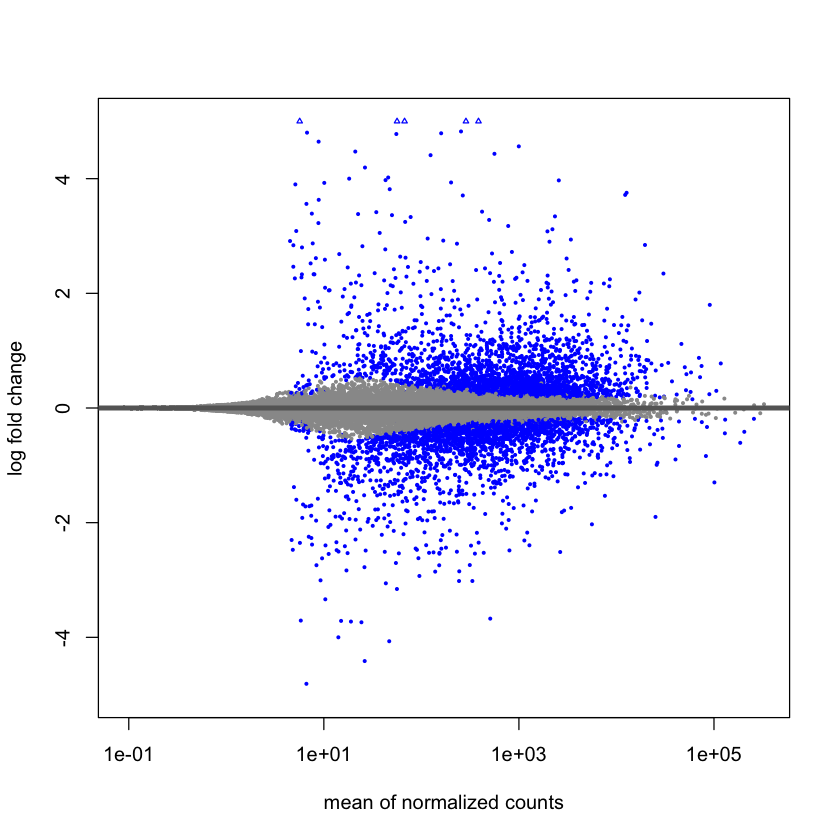

In [16]:
res <- lfcShrink(dds, coef = 'dex_trt_vs_untrt', type="apeglm")
plotMA(res, ylim = c(-5, 5))

**An MA-plot of changes induced by treatment.**
The log2 fold-change for a particular
comparison is plotted on the y-axis and the average of the counts
normalized by size factor is shown on the x-axis.
Each gene is represented with a dot. Genes with an adjusted *p* value
below a threshold (here 0.1, the default) are shown in red.

The *DESeq2* package uses a Bayesian procedure to moderate (or
"shrink") log2 fold changes from genes with very low counts and highly
variable counts, as can be seen by the narrowing of the vertical
spread of points on the left side of the MA-plot. As shown above, the
`lfcShrink` function performs this operation.  For a detailed
explanation of the rationale of moderated fold changes, please see the
*DESeq2* paper ([Love and Huber, Genome Biology, 2014](http://wwwf.imperial.ac.uk/~das01/BioinformaticsMSc/Papers/sinica.final.pdf)).

If we had not used statistical moderation to shrink the noisy log2
fold changes, we would have instead seen the following plot:

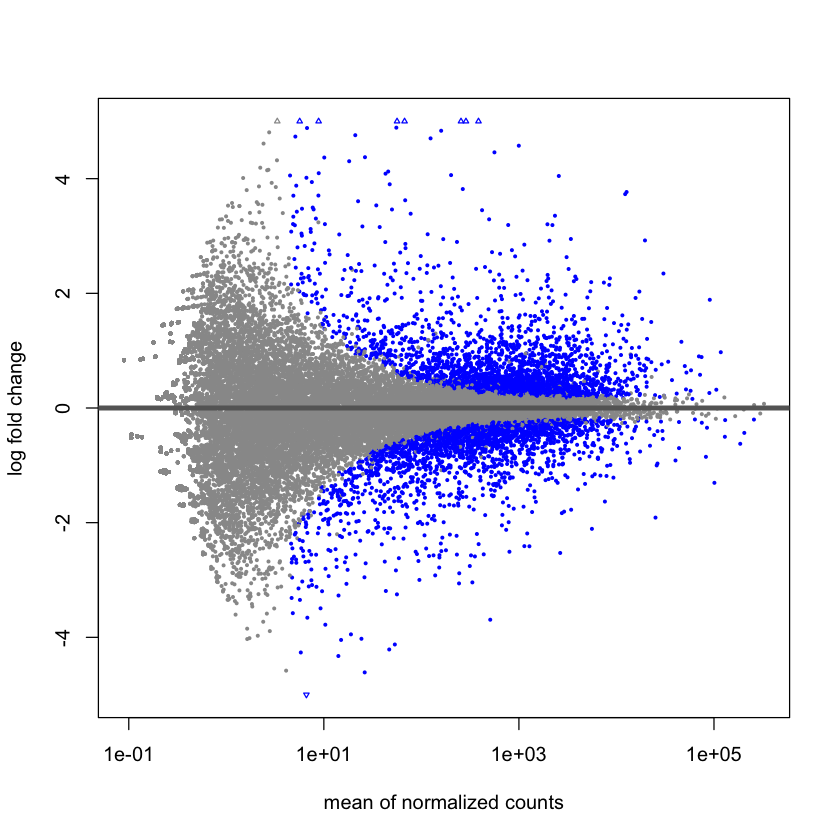

In [90]:
res.noshr <- results(dds)
plotMA(res.noshr, ylim = c(-5, 5))


We can label individual points on the MA-plot as well. Here we use the
`with` R function to plot a circle and text for a selected row of the
results object. Within the `with` function, only the `baseMean` and
`log2FoldChange` values for the selected rows of `res` are used.

In [ ]:
plotMA(res, ylim = c(-5,5))
topGene <- rownames(res)[which.min(res$padj)]
with(res[topGene, ], {
  points(baseMean, log2FoldChange, col="dodgerblue", cex=2, lwd=2)
  text(baseMean, log2FoldChange, topGene, pos=2, col="dodgerblue")
})


Another useful diagnostic plot is the histogram of the p-values
(figure below). This plot is best formed by excluding genes with very
small counts, which otherwise generate spikes in the histogram.

In [ ]:
hist(res$pvalue[res$baseMean > 1], breaks = 0:20/20,
     col = "grey50", border = "white", main = "p-value Histogram", xlab = "p-value")

**Histogram of *p* values for genes with mean normalized count larger than 1.**

## Volcano plot

A typical volcano plot is a scatterplot of $-log_{10}$(p-value) vs. $log_2$(fold-change). It allows you to visualize the difference in expression between groups against the statistical significance of that difference. Some things to look for:
* are diffentially expressed genes skewed towards up or down-regulation?
* are there a lot of significant but very low fold-change genes? This can result from a confounded batch effect.

In [ ]:
volcanoPlot <- function(res, lfc=2, pval=0.01){
    tab = data.frame(logFC = res$log2FoldChange, negLogPval = -log10(res$pvalue))
    plot(tab, pch = 16, cex = 0.6, xlab = expression(log[2]~fold~change), ylab = expression(-log[10]~pvalue))
    signGenes = (abs(tab$logFC) > lfc & tab$negLogPval > -log10(pval))
    points(tab[signGenes, ], pch = 16, cex = 0.8, col = "red") 
    abline(h = -log10(pval), col = "green3", lty = 2) 
    abline(v = c(-lfc, lfc), col = "blue", lty = 2) 
    mtext(paste("pval =", pval), side = 4, at = -log10(pval), cex = 0.8, line = 0.5, las = 1) 
    mtext(c(paste("-", lfc, "fold"), paste("+", lfc, "fold")), side = 3, at = c(-lfc, lfc), cex = 0.8, line = 0.5)
}
volcanoPlot(res)

# Visualizing differential expression results

## A Note on Counts in DESeq2

When performing its analysis, DESeq2 performs count normaliziation to correct for factors such as library size.  It does so in an attempt to abrogate the effects of count magnitude on differential expression status - otherwise, nonsignificant genes with very large counts would appear as false positives and significant genes with very small counts would appear as false negatives.

Common methods of normalization include TMM (Trimmed Mean of M-Values), RLE (Relative Log Expression), and MRN (Median Ratio Normalization).  TMM and RLE, used by edgeR and DESeq2, yield very similar results.

When obtaining a result from DESeq highlighting a list of genes, people will often look back at their original count table using a program like Excel and examine the counts tabulated therein.  **Doing so is inadvisable and misleading**, as these non-normalized counts are not proper indicators of significance.

Here, we will show how different normalized and nonnormalized counts can be.  Note that these plots are on the log scale, so a linear distance represents an exponential change.  Very low counts are unaffected by normalization, as the normalization process adds a 0.5 pseudocount, but higher counts change substantially.  Here, **the two lower counts in the treatment group are almost halved and almost doubled in magnitude, respectively** - an enormous change that would be misleading if viewed without factoring in the normalization.


## Counts plot

A quick way to visualize the counts for a particular gene is to use
the *plotCounts* function that takes as arguments the
*DESeqDataSet*, a gene name, and the group over which to plot the
counts (figure below).

In [ ]:
par(mfrow=c(1,2))
topGene <- rownames(res)[which.min(res$padj)]
plotCounts(dds, gene = "ENSG00000132518", intgroup=c("dex"), main = "Normalized")
plotCounts(dds, gene = "ENSG00000132518", intgroup=c("dex"), normalized = F, main = "Non-normalized")


**Normalized counts for a single gene over treatment group.**


# Ontology Analysis

Now that we have retrieved a list of differentially expressed genes, we will generally proceed to use this list to draw biological insight via "gene ontology" analysis - basically, using lists of terms associated with genes to figure out which pathways are being modified in a cohesive manner.

Simply put, the general principle is to test whether known biological functions or processes are over-represented
(= enriched) in an experimentally-derived gene list, e.g. a list of
differentially expressed (DE) genes computed by DEseq - see
[Goeman and Buehlmann, 2007](https://doi.org/10.1093/bioinformatics/btm051) for
a critical review.

Example: Transcriptomic study, in which 12,671 genes have been tested for
differential expression between two sample conditions and 529 genes were found
DE.

Among the DE genes, 28 are annotated to a specific functional gene set, which
contains in total 170 genes. This setup corresponds to a 2x2 contingency table:

In [ ]:
deTable <-
     matrix(c(28, 142, 501, 12000),
            nrow = 2,
            dimnames = list(c("DE", "Not.DE"),
                            c("In.gene.set", "Not.in.gene.set")))
deTable

where the overlap of 28 genes can be assessed based on the [hypergeometric distribution](https://en.wikipedia.org/wiki/Hypergeometric_distribution).
This corresponds to a one-sided version of Fisher's exact test, yielding here a
significant enrichment.

In [ ]:
fisher.test(deTable, alternative = "greater")

Many genes fall into more than one category:

<img src="https://raw.githubusercontent.com/compbiocore/deseq-workshop-2/master/docs/assets/gabra.png" alt="gaba" style="width:500px">

R will keep track of all the terms associated with a given gene depending on which database you use for your analysis.  The most well-known databases are GO and KEGG, both of which are implemented in R.  Today, we'll see an example using GO, as implemented in [the `goseq` package created by Jeff Leek](https://bioconductor.org/packages/release/bioc/html/goseq.html).

First, we will load the package and see what genomes it supports.  Then, we'll format our data in the manner expected by the package.

In [ ]:
library(goseq)

In [ ]:
head(supportedGenomes())

We take our list of genes, subset by adjusted p-value, and then remove the missing values.

In [ ]:
#test.ids <- rownames(resSig[ order(resSig$log2FoldChange, decreasing = TRUE), ])
#head(test.ids)

goseq.genes <- as.integer(res$padj < 0.1)
not.na <- !is.na(goseq.genes)
names(goseq.genes) <- rownames(res)
goseq.genes <- goseq.genes[not.na]

Next, we generate a "weighting function" by specifying which genome to use and by denoting what type of IDs our genes are listed using (Ensembl IDs):

In [ ]:
pwf <- nullp(goseq.genes, "hg19", "ensGene")

In [ ]:
head(pwf)

Finally, we run the `goseq` function, once again specifying the annotation and ID type

In [ ]:
go.wall <- goseq(pwf, "hg19", "ensGene")

In [ ]:
head(go.wall, 20)

As can be seen, however, these GO terms are often quite broad and may not be particularly informative in a given analysis.  Thus, we will also take a look at another approach that specifically examines disease states and their associated pathologies.  In doing so, we will create a variety of visualizations of these disease-related terms, most notably those included in [the 'enrichplot' package by Guangchuang Yu](https://bioconductor.org/packages/release/bioc/html/enrichplot.html).

However, this package does not allow us to use the raw Ensembl IDs that were accommodated by `goseq`.  Thus, we must first discuss a common operation performed during the course of RNA-seq analysis - ID mapping, the process by which one type of ID is translated into another.

## ID Mapping

Before we perform our `enrichplot` ontology analysis, however, we need to be sure that our gene IDs are tabulated using the correct identification scheme.  There are many different types of IDs that can be used in genomics, including the Ensembl ID, the Entrez ID, the gene symbol, and more.  It is fundamental that we are aware of exactly what type of ID we are dealing with, as ontology analysis packages often require the IDs to be provided in a very specific manner.

In [ ]:
test.ids <- rownames(resSig[ order(resSig$log2FoldChange, decreasing = TRUE), ])
head(test.ids)

Looking at our IDs, we can see that they all follow a specific format - that is, ENSG\*.  These abbreviations mean "Ensembl Gene \*", and are examples of Ensembl IDs.  The enrichplot package requires us to have a list of IDs in Entrez format, the scheme used by NCBI, so we must first convert our Ensembl IDs to Entrez IDs.  This process can be accomplished simply using the `mapIds` function.  Note that in this function, the first ID argument is the ID type we want, while the second ID argument is the ID type we already have, which can be a bit confusing.

Also note the `org.Hs.eg.db` argument - that refers to the database being used internally to perform the mapping.  Since human genes are well-characterized, this database is conveniently available as an R package that `mapIds` can directly interface with.

In [ ]:
#entrez.ids <- mapIds(org.Hs.eg.db, "ENSG00000179593", "ENTREZID", "ENSEMBL")
#entrez.ids

In [ ]:
head(resSig[ order(resSig$log2FoldChange, decreasing = TRUE), 2])

In [ ]:
ids.fc <- cbind(rownames(resSig[ order(resSig$log2FoldChange, decreasing = TRUE), ]), (resSig[ order(resSig$log2FoldChange, decreasing = TRUE), 2]))
head(ids.fc)

In [ ]:
entrez.ids <- mapIds(org.Hs.eg.db, ids.fc[, 1], "ENTREZID", "ENSEMBL")
head(entrez.ids)
table(is.na(entrez.ids))

As we can see, there are some NAs present within the dataset after performing the mapping.  Most ID schema do not map with 100% fidelity onto other ID schema, so this behavior is expected - we must always check to be sure that there are no NAs, and if any are found (as is the case here), we must remove them and their associated values.

Note that these NAs are NOT due to the differential expression analysis itself, but due to the mapping process.  Thus, our prior NA removal will not account for them.  Here, we locate which values are not NA and preserve them.

In [ ]:
ids.fc[, 1] <- unname(entrez.ids)
ids.fc.no.missing <- ids.fc[!is.na(ids.fc[, 1]), ]
head(ids.fc.no.missing)

We now have a list of valid Entrez IDs that can be used for futher analysis with enrichplot.  We will assign these IDs to the `names` metadata of the object so that enrichplot knows how to interpret the gene IDs.  Note that no visible change is made to the object.

In [ ]:
#entrez.ids <- as.character(ids.fc.no.missing[, 1])
#head(entrez.ids)
#ids.fc.no.missing <- ids.fc.no.missing[,-1]
#head(ids.fc.no.missing)
names(ids.fc.no.missing) <- entrez.ids
head(ids.fc.no.missing)

In [ ]:
library(DOSE)

In [ ]:
fc.vector <- as.numeric(ids.fc.no.missing[, 2])
names(fc.vector) <- ids.fc.no.missing[, 1]

class(ids.fc.no.missing)
class(fc.vector)

head(fc.vector)

This object looks quite similar to the table we generated above, but it is actually quite different: instead of a data frame, it is a named numeric vector, the type of input required by enrichplot.  We will keep this vector for further analysis.  The next step requires only the names, however, so we will extract them again and store them separately as we create our graphs.  The fold change is retained in the original object so we can subset by fold change magnitude as desired when extracting names for `enrichplot` analysis.

In [ ]:
#de <- names(ids.fc)[abs(ids.fc) > 2]
de.names <- names(fc.vector)
de.names.subset <- names(fc.vector)[abs(fc.vector) > 2]


edo <- enrichDGN(de.names)
edo.subset <- enrichDGN(de.names.subset)

Here, we are going to run a disease state analysis on two sets of genes: all significant genes, and all significant genes with a fold change magnitude above 2 (i.e. > 2, < -2).  The resulting disease states will be colored by significance, with the length of their bars determined by the number of genes within the category.

In [ ]:
par(mfrow=c(1,2))
barplot(edo, showCategory=20)
barplot(edo.subset, showCategory=20)

Here, we see an example of a dot plot.  We only show the all-gene case because these plots depict the exact same finding as the bar plots, merely displaying them in a different manner that not only shows the proportion of genes but also the raw counts (shown through point radius).

In [ ]:
p1 <- dotplot(edo, showCategory=30) + ggtitle("dotplot for ORA")
plot_grid(p1, ncol=1)

Next, we present a network map of these terms that show associations among the various disease states as determined by common genes that fall into multiple categories.  This graphical display is useful for seeing how the significant genes work in concert with one another.

Here, we see an object lesson in why it is advantageous to look at subsets of genes: the network map of all significant genes is so dense that it is illegibile, but the map of the genes with the most extreme fold change is easy to interpret.

In [ ]:
edox <- setReadable(edo, 'org.Hs.eg.db', 'ENTREZID')
cnetplot(edox, foldChange=de.names)

edox.subset <- setReadable(edo.subset, 'org.Hs.eg.db', 'ENTREZID')
cnetplot(edox.subset, foldChange=de.names.subset)

Finally, we present the `upsetplot` - this type of diagram uses another method for showing the network association among genes and gene sets.  It is a bit difficult to interpret, but does not run into problems with large numbers of genes.

Here, on the bottom left, we see the various gene sets and their size.  To the right, we see dots showing groups of genes that fall into each category (the bars).  When one bar has two or more dots, their dots are connected, and this connection means that the genes in that set are linked.

`upsetplot` is an excellent way to clearly display the intersection among many genes.  It can be understood as analogous to a Venn diagram showing set overlaps, but a Venn diagram can only show at most 6 sets - the upsetplot does not have any such limitation.

In [ ]:
upsetplot(edo)

# Conclusion

There are countless other ways to perform ontology analysis and represent the results thereof - far more than could be covered in any workshop.  Users are encoraged to read through the documentation and vignettes of the packages discussed here today - there is plenty to discover within.  We've covered the methods for mapping IDs and reshaping the data to accommodate numerous types of functions, and these principles broadly apply to the other methods.

If you use the results from an R analysis package in published
research, you can find the proper citation for the software by typing
`citation("pkgName")`, where you would substitute the name of the
package for `pkgName`.  Citing methods papers helps to support and
reward the individuals who put time into developing free and open source software for
genomic data analysis.

For any questions related to this material, or to submit a request for assistance in conducting your own ontology analysis, please contact us at cbc-help@brown.edu

# Appendix A

One easy-to-use GUI-based method for ontology analysis is [DAVID](https://david.ncifcrf.gov/) - this tool has sample datasets within it that can be used to preview its functions.  It does not lend itself well for use in this workshop, due to the need to write to files and then input those files into DAVID, which would require some further explanation due to the Jupyter environment.  Users should feel free to visit the site and use the example data, though.

#  Hypothesis testing for count data


Generalized Linear Models (GLM) are a broad family of regression models, a small subset of which form the basis for differential expression and other hypothesis testing in genomics.

The components of a GLM are:

$$
g\left( E[y|x] \right) = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_p x_{pi}
$$

* **Random component** specifies the conditional distribution for the response variable
    + doesn’t have to be normal
    + can be any distribution in the "exponential" family of distributions
* **Systematic component** specifies linear function of predictors (linear predictor)
* **Link** [denoted by g(.)] specifies the relationship between the expected value of the random component and the systematic component
    + can be linear or nonlinear  

## Linear Regression as GLM

This is useful for log-transformed microarray data:

* **The model**: $y_i = E[y|x] + \epsilon_i = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_p x_{pi} + \epsilon_i$
* **Random component** of $y_i$ is normally distributed:   $\epsilon_i \stackrel{iid}{\sim} N(0, \sigma_\epsilon^2)$
* **Systematic component** (linear predictor): $\beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_p x_{pi}$
* **Link function** here is the _identity link_: $g(E(y | x)) = E(y | x)$.  We are modeling the mean directly, no transformation.

## Logistic Regression as GLM

This is useful for binary outcomes, e.g. Single Nucleotide Polymorphisms or somatic variants:

* **The model**: 
$$
Logit(P(x)) = log \left( \frac{P(x)}{1-P(x)} \right) = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_p x_{pi}
$$
* **Random component**: $y_i$ follows a Binomial distribution (outcome is a binary variable)
* **Systematic component**: linear predictor 
$$
\beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_p x_{pi}
$$
* **Link function**: _logit_ (log of the odds that the event occurs)
$$
g(P(x)) = logit(P(x)) = log\left( \frac{P(x)}{1-P(x)} \right)
$$

## Log-linear GLM

This is useful for count data, like RNA-seq. It can:
    + account for differences in sequencing depth
    + guarantee non-negative expected number of counts
    + be used in conjunction with Poisson or Negative Binomial error models

* **The model** (`log(t_i)` is called an "offset" term):
$$
log\left( E[y|x] \right) = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_p x_{pi} + log(t_i)  
$$

Without getting into details of Poisson or Negative Binomial error terms, they are just random distributions that happen to fit many count data well:

In [ ]:
options(repr.plot.height=5, repr.plot.width=7)
plot(x=0:40, y=dnbinom(0:40, size=10, prob=0.5), 
     type="b", lwd=2, ylim=c(0, 0.15),
     xlab="Counts (k)", ylab="Probability density")
lines(x=0:40, y=dnbinom(0:40, size=20, prob=0.5), 
      type="b", lwd=2, lty=2, pch=2)
lines(x=0:40, y=dnbinom(0:40, size=10, prob=0.3),
      type="b", lwd=2, lty=3, pch=3)
lines(x=0:40, y=dpois(0:40, lambda=9), col="red")
lines(x=0:40, y=dpois(0:40, lambda=20), col="red")
legend("topright", lwd=c(2,2,2,1), lty=c(1:3,1), pch=c(1:3,-1), col=c(rep("black", 3), "red"),
       legend=c("n=10, p=0.5", "n=20, p=0.5", "n=10, p=0.3", "Poisson"))

**Figure**: Two Poisson distributions (shown as red lines), and three Negative Binomial (NB) distributions selected for having similarly located peak probabilities. Note the greater dispersion and the tunability of NB distribution. Also note that probabilities are only non-zero defined for integer values.

#  Small samples, large samples, and the Central Limit Theorem

## What is a _sampling distribution_?

It is the distribution of a statistic for many samples taken from one population.
 
1. Take a sample from a population
2. Calculate the sample statistic (e.g. mean)
3. Repeat.  

- The values from (2) form a sampling distribution.
- The standard deviation of the sampling distribution is the _standard error_

- Question: how is this different from a population distribution?

## Example: population and sampling distributions

We observe 100 counts from a Poisson distribution ($\lambda = 2$). 
* Question: is this a population or a sampling distribution?

In [ ]:
options(repr.plot.height=3, repr.plot.width=3)
set.seed(1)
onesample=rpois(100, lambda=2)
xdens = seq(min(onesample), max(onesample), by=1)
ydens = length(onesample) * dpois(xdens, lambda=2)
par(mar=c(2, 4, 0.1, 0.1))
options(repr.plot.width=4, repr.plot.height=3)
res=hist(onesample, main="", prob=FALSE, col="lightgrey", xlab="", ylim=c(0, max(ydens)),
     breaks=seq(-0.5, round(max(onesample))+0.5, by=0.5))
lines(xdens, ydens, lw=2)

We calculate the *mean* of those 100 counts, and do the same for 1,000 more samples of 100:
* Question: is this a population or a sampling distribution?

In [ ]:
set.seed(1)
samplingdistr=replicate(1000, mean(rpois(100, lambda=2)))
par(mar=c(4, 4, 0.1, 0.1))
res=hist(samplingdistr, xlab="Means of the 100-counts", main="")
dy=density(samplingdistr, adjust=2)
## Note this next step is just an empirical way to put the density line approximately the same scale as the histogram:
dy$y = dy$y / max(dy$y) * max(res$counts)
lines(dy)

## Central Limit Theorem

The "CLT" relates the sampling distribution (of means) to the population distribution.

1. Mean of the population ($\mu$) and of the sampling distribution ($\bar{X}$) are identical
2. Standard deviation of the population ($\sigma$) is related to the standard deviation of the distribution of sample means (*Standard Error* or *SE*) by: 
$$
SE = \sigma / \sqrt{n}
$$
3. For large n, the shape of the sampling distribution of means becomes normal

### CLT 1: equal means

Recall Poisson distributed population and samples of n=30:

In [ ]:
options(repr.plot.width=6, repr.plot.height=3)
par(mfrow=c(1,2))
hist(onesample, main="One sample of 100 counts\n from Poisson(lambda=2)", xlab="counts")
abline(v=2, col="red", lw=2)
res=hist(samplingdistr, xlab="Means of the 100-counts", main="1000 samples\n of n=100")
abline(v=2, col="red", lw=2)

- Distributions are different, but means are the same

### CLT 2: Standard Error

Standard deviation of the sampling distribution is $SE = \sigma / \sqrt{n}$:

In [ ]:
options(repr.plot.width=6, repr.plot.height=3)
par(mfrow=c(1,3))
hist(replicate(1000, mean(rpois(30, lambda=2))), xlim=c(1.3, 3),
     xlab="Means of 30-counts", main="1000 samples\n of n=30")
abline(v=2, col="red", lw=2)
hist(replicate(1000, mean(rpois(100, lambda=2))), xlim=c(1.3, 3),
     xlab="Means of 100-counts", main="1000 samples\n of n=100")
abline(v=2, col="red", lw=2)
hist(replicate(1000, mean(rpois(500, lambda=2))), xlim=c(1.3, 3),
     xlab="Means of 500-counts", main="1000 samples\n of n=500")
abline(v=2, col="red", lw=2)

### CLT 3: large samples

- The distribution of means of large samples is normal. 
    + for large enough n, the population distribution doesn't matter. How large?
    + n < 30: population is normal or close to it
    + n >= 30: skew and outliers are OK
    + n > 500: even extreme population distributions

*Example*: an extremely skewed (log-normal) distribution:

In [ ]:
options(repr.plot.width=6, repr.plot.height=3)
par(mfrow=c(1,3))
set.seed(5)
onesample=rlnorm(n=100, sdlog=1.5)
hist(onesample, main="100 observations\n from lognormal pop'n", xlab="counts")
sampling30=replicate(1000, mean(rlnorm(n=30, sdlog=1.5)))
hist(sampling30, xlab="Means of the 100 obs.", main="1000 samples\n of n=30")
sampling1000=replicate(1000, mean(rlnorm(n=1000, sdlog=1.5)))
hist(sampling1000, xlab="Means of the 1000 obs.", main="1000 samples\n of n=1000")

#  Correcting for batch effects

Suppose we did not know that there were different cell lines involved
in the experiment, only that there was treatment with
dexamethasone. The cell line effect on the counts then would represent
some hidden and unwanted variation that might be affecting
many or all of the genes in the dataset. We can use statistical
methods designed for RNA-seq from the 
[sva](http://www.bioconductor.org/packages/Gviz) package to
detect such groupings of the samples, and then we can add these to the
*DESeqDataSet* design, in order to account for them. The *SVA*
package uses the term *surrogate variables* for the estimated
variables that we want to account for in our analysis. Another
package for detecting hidden batches is the [RUVSeq](http://www.bioconductor.org/packages/RUVSeq)
package, with the acronym "Remove Unwanted Variation".

In [ ]:
suppressPackageStartupMessages(library(sva))

Below we obtain a matrix of normalized counts for which the average count across
samples is larger than 1. As we described above, we are trying to
recover any hidden batch effects, supposing that we do not know the
cell line information. So we use a full model matrix with the
*dex* variable, and a reduced, or null, model matrix with only
an intercept term. Finally we specify that we want to estimate 2
surrogate variables. For more information read the manual page for the
*svaseq* function by typing `?svaseq`.

In [ ]:
dat  <- counts(dds, normalized = TRUE)
idx  <- rowMeans(dat) > 1
dat  <- dat[idx, ]
mod  <- model.matrix(~ dex, colData(dds))
mod0 <- model.matrix(~   1, colData(dds))
svseq <- svaseq(dat, mod, mod0, n.sv = 2)

In [ ]:
svseq$sv

Because we actually do know the cell lines, we can see how well the
SVA method did at recovering these variables (figure below).

In [ ]:
options(repr.plot.height=5)
par(mfrow = c(2, 1), mar = c(3,5,3,1))
for (i in 1:2) {
  stripchart(svseq$sv[, i] ~ dds$cell, vertical = TRUE, main = paste0("SV", i))
  abline(h = 0)
 }

![](BrownCOBREDay2Session2_files/figure-html/svaplot-1.png)<!-- -->

**Surrogate variables 1 and 2 plotted over cell line.**
Here, we know the hidden source of variation (cell line), and
therefore can see how the SVA procedure is able to identify a source
of variation which is correlated with cell line.

Finally, in order to use SVA to remove any effect on the counts from
our surrogate variables, we simply add these two surrogate variables
as columns to the *DESeqDataSet* and then add them to the design:

In [ ]:
ddssva <- dds
ddssva$SV1 <- svseq$sv[,1]
ddssva$SV2 <- svseq$sv[,2]
design(ddssva) <- ~ SV1 + SV2 + dex

We could then produce results controlling for surrogate variables by
running *DESeq* with the new design:

In [ ]:
DESeq(ddssva)



## Gene clustering

In the sample distance heatmap made in our previous workshop, the dendrogram at the
side shows us a hierarchical clustering of the samples. Such a
clustering can also be performed for the genes.  Since the clustering
is only relevant for genes that actually carry a signal, one usually
would only cluster a subset of the most highly variable genes. Here,
for demonstration, let us select the 20 genes with the highest
variance across samples. We will work with the *rlog*-transformed
counts:

In [ ]:
rld <- rlog(dds, blind=FALSE, fitType="mean")
suppressPackageStartupMessages(library(genefilter))
topVarGenes <- head(order(rowVars(assay(rld)), decreasing = TRUE), 20)

The heatmap becomes more interesting if we do not look at absolute
expression strength but rather at the amount by which each gene
deviates in a specific sample from the gene's average across all
samples. Hence, we center each genes' values across samples,
and plot a heatmap (figure below). We provide a *data.frame* that instructs the
*pheatmap* function how to label the columns.

In [ ]:
library(pheatmap)
mat  <- assay(rld)[ topVarGenes, ]
mat  <- mat - rowMeans(mat)
anno <- as.data.frame(colData(rld)[, c("cell","dex")])
pheatmap(mat, annotation_col = anno)


**Heatmap of relative rlog-transformed values across samples.**
Treatment status and cell line information are shown with colored bars
at the top of the heatmap.
Blocks of genes that covary across patients. Note that
a set of genes at the top of the heatmap are separating the N061011
cell line from the others. In the center of the heatmap, we see a set
of genes for which the dexamethasone treated samples have higher gene
expression. 

## Stratified random sampling
- done with population sampling

<img src="https://upload.wikimedia.org/wikipedia/commons/a/a2/StratifiedRandomSampling.jpg" alt="SRS" style="width:400px"> 

- divides population into more homogeneous subpopulations
    + during design, strata are normally with predetermined probabilities
 
## Stratification in analysis
- experimental blocks and population strata could either be treated as factors or strata for analysis
    + stratification is necessary when you think a factor in a linear model is inadequate to capture differences between nuisance strata
- observations are:
    + divided into strata
    + strata are analyzed independently
    + results are then averaged across strata